In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [25]:
plt.rcParams['font.sans-serif'] = ['STZhongsong']  # 设置中文为“华文中宋”
plt.rcParams['font.family'] = ['STZhongsong', 'Times New Roman']  # 设置英文字体为 Times New Roman
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

## Data cleaning

In [3]:
housing_df = pd.read_csv("fang_housing_data_whole.csv")
rental_df = pd.read_csv("fang_rental_data_whole.csv")

In [13]:
housing_df_xisanqi = pd.read_csv("xisanqi_house_beijing.csv")
rental_df_xisanqi = pd.read_excel("xisanqi_beijing_fang_rentals.xlsx")
housing_df_xierqi = pd.read_csv("西二旗-二手房.csv")
rental_df_xierqi = pd.read_csv("西二旗-租房.csv")
housing_df_qinghe = pd.read_csv("qinghe_house_prices_area.csv")
rental_df_qinghe = pd.read_csv("qinghe_rent_prices_area.csv")

In [19]:
print(housing_df_xisanqi.columns)
print(rental_df_xisanqi.columns)
print(housing_df_xierqi.columns)
print(rental_df_xierqi.columns)
print(housing_df_qinghe.columns)
print(rental_df_qinghe.columns)

Index(['房屋名称', '户型', '建筑面积', '朝向', '总价', '单价'], dtype='object')
Index(['房产名称', '租金', '房屋面积', '户型', '朝向'], dtype='object')
Index(['面积', '总价', '单价'], dtype='object')
Index(['面积', '总价', '单价'], dtype='object')
Index(['price', 'area'], dtype='object')
Index(['price', 'area'], dtype='object')


In [21]:
# 标准化西三旗数据列名
housing_df_xisanqi = housing_df_xisanqi.rename(columns={
    '建筑面积': 'Area',
    '总价': 'TotalPrice',
    '单价': 'PricePerSqm'
})
rental_df_xisanqi = rental_df_xisanqi.rename(columns={
    '租金': 'MonthlyRent',
    '房屋面积': 'Area'
})

In [23]:
# 标准化西二旗数据列名
housing_df_xierqi = housing_df_xierqi.rename(columns={
    '面积': 'Area',
    '总价': 'TotalPrice',
    '单价': 'PricePerSqm'
})

rental_df_xierqi = rental_df_xierqi.rename(columns={
    '面积': 'Area',
    '总价': 'MonthlyRent',
    '单价': 'RentPerSqm'  # 假设这是每平米月租金
})

In [24]:
# 标准化清河数据列名
housing_df_qinghe = housing_df_qinghe.rename(columns={
    'price': 'TotalPrice',
    'area': 'Area'
})

rental_df_qinghe = rental_df_qinghe.rename(columns={
    'price': 'MonthlyRent',
    'area': 'Area'
})

In [26]:
# 数据清洗和准备
# 对西三旗数据进行数值转换(如果数据类型不是数值型)
housing_df_xisanqi['Area'] = housing_df_xisanqi['Area'].astype(str).str.extract('(\d+\.\d+|\d+)').astype(float)
housing_df_xisanqi['TotalPrice'] = housing_df_xisanqi['TotalPrice'].astype(str).str.extract('(\d+\.\d+|\d+)').astype(float)
housing_df_xisanqi['PricePerSqm'] = housing_df_xisanqi['PricePerSqm'].astype(str).str.extract('(\d+\.\d+|\d+)').astype(float)

rental_df_xisanqi['MonthlyRent'] = rental_df_xisanqi['MonthlyRent'].astype(str).str.extract('(\d+\.\d+|\d+)').astype(float)
rental_df_xisanqi['Area'] = rental_df_xisanqi['Area'].astype(str).str.extract('(\d+\.\d+|\d+)').astype(float)

# 为每个数据集添加Block标识
housing_df['Block'] = '上地'
rental_df['Block'] = '上地'
housing_df_xisanqi['Block'] = '西三旗'
rental_df_xisanqi['Block'] = '西三旗'
housing_df_xierqi['Block'] = '西二旗'
rental_df_xierqi['Block'] = '西二旗'
housing_df_qinghe['Block'] = '清河'
rental_df_qinghe['Block'] = '清河'

# 计算每平方米的租金(如果尚未计算)
if 'RentPerSqm' not in rental_df.columns:
    rental_df['RentPerSqm'] = rental_df['MonthlyRent'] / rental_df['Area']
    
if 'RentPerSqm' not in rental_df_xisanqi.columns:
    rental_df_xisanqi['RentPerSqm'] = rental_df_xisanqi['MonthlyRent'] / rental_df_xisanqi['Area']
    
if 'RentPerSqm' not in rental_df_qinghe.columns:
    rental_df_qinghe['RentPerSqm'] = rental_df_qinghe['MonthlyRent'] / rental_df_qinghe['Area']

# 如果西二旗的数据集没有PricePerSqm，就计算它
if 'PricePerSqm' not in housing_df_qinghe.columns:
    housing_df_qinghe['PricePerSqm'] = housing_df_qinghe['TotalPrice'] * 10000 / housing_df_qinghe['Area']

# 统一单位: 确保所有总价是以万元为单位，单价是以元/平方米为单位
# 为所有数据集创建TotalPriceYuan字段(元)
housing_df['TotalPriceYuan'] = housing_df['TotalPrice'] * 10000
housing_df_xisanqi['TotalPriceYuan'] = housing_df_xisanqi['TotalPrice'] * 10000
housing_df_xierqi['TotalPriceYuan'] = housing_df_xierqi['TotalPrice'] * 10000
housing_df_qinghe['TotalPriceYuan'] = housing_df_qinghe['TotalPrice'] * 10000

# 创建年租金字段
rental_df['YearlyRent'] = rental_df['MonthlyRent'] * 12
rental_df_xisanqi['YearlyRent'] = rental_df_xisanqi['MonthlyRent'] * 12
rental_df_xierqi['YearlyRent'] = rental_df_xierqi['MonthlyRent'] * 12
rental_df_qinghe['YearlyRent'] = rental_df_qinghe['MonthlyRent'] * 12


<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:7: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:7: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\d'
C:\Users\86187\AppData\Local\Temp\ipykernel_20940\490368832.py:3: SyntaxWarning: invalid escape sequence '\d'
  housing_df_xisanqi['Area'] = housing_df_xisanqi['Area'].astype(str).str.extract('(\d+\.\d+|\d+)').astype(float)
C:\Users\86187\AppData\Local\Temp\ipykernel_20940\490368832.py:4: SyntaxWarning: invalid escape sequence '\d'
  housing_df_xisanqi['TotalPrice'] = housing_df_xisanqi['TotalPrice'].astype(str).str.extract('(\d+\.\d+|\d+)').astype(float)
C:\Users\86187\AppData\Local\Temp\ipyker

In [27]:
# 合并所有数据集
all_housing = pd.concat([housing_df, housing_df_xisanqi, housing_df_xierqi, housing_df_qinghe])
all_rental = pd.concat([rental_df, rental_df_xisanqi, rental_df_xierqi, rental_df_qinghe])

## 1. 数据描述与异常值检测

In [4]:
print("二手房数据描述：")
print(housing_df.describe())

print("\n租房数据描述：")
print(rental_df.describe())

二手房数据描述：
        TotalPrice        Area    PricePerSqm
count   600.000000  600.000000     600.000000
mean   1127.530000  112.537017  106346.980000
std     454.599476   51.240943   25266.586011
min     350.000000   41.070000   57500.000000
25%     820.000000   71.000000   84057.000000
50%    1046.500000  107.000000  105347.000000
75%    1298.000000  146.100000  124908.000000
max    3500.000000  314.710000  162466.000000

租房数据描述：
        MonthlyRent        Area
count    388.000000  388.000000
mean    6701.247423   69.693299
std     5005.644872   63.494908
min     1000.000000    6.000000
25%     2400.000000   18.000000
50%     5800.000000   45.000000
75%    11000.000000  119.250000
max    19000.000000  273.000000


In [5]:
# 检查异常值 - 使用IQR方法
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers


In [6]:
# 检查房价、面积和每平米价格的异常值
price_outliers = detect_outliers(housing_df, 'TotalPrice')
area_outliers_housing = detect_outliers(housing_df, 'Area')
price_per_sqm_outliers = detect_outliers(housing_df, 'PricePerSqm')


In [7]:
# 检查租金和面积的异常值
rent_outliers = detect_outliers(rental_df, 'MonthlyRent')
area_outliers_rental = detect_outliers(rental_df, 'Area')

In [8]:
print("\n二手房数据中的异常值：")
print(f"总价异常值数量: {len(price_outliers)}")
print(f"面积异常值数量: {len(area_outliers_housing)}")
print(f"每平米价格异常值数量: {len(price_per_sqm_outliers)}")

print("\n租房数据中的异常值：")
print(f"月租金异常值数量: {len(rent_outliers)}")
print(f"面积异常值数量: {len(area_outliers_rental)}")


二手房数据中的异常值：
总价异常值数量: 15
面积异常值数量: 9
每平米价格异常值数量: 0

租房数据中的异常值：
月租金异常值数量: 0
面积异常值数量: 12


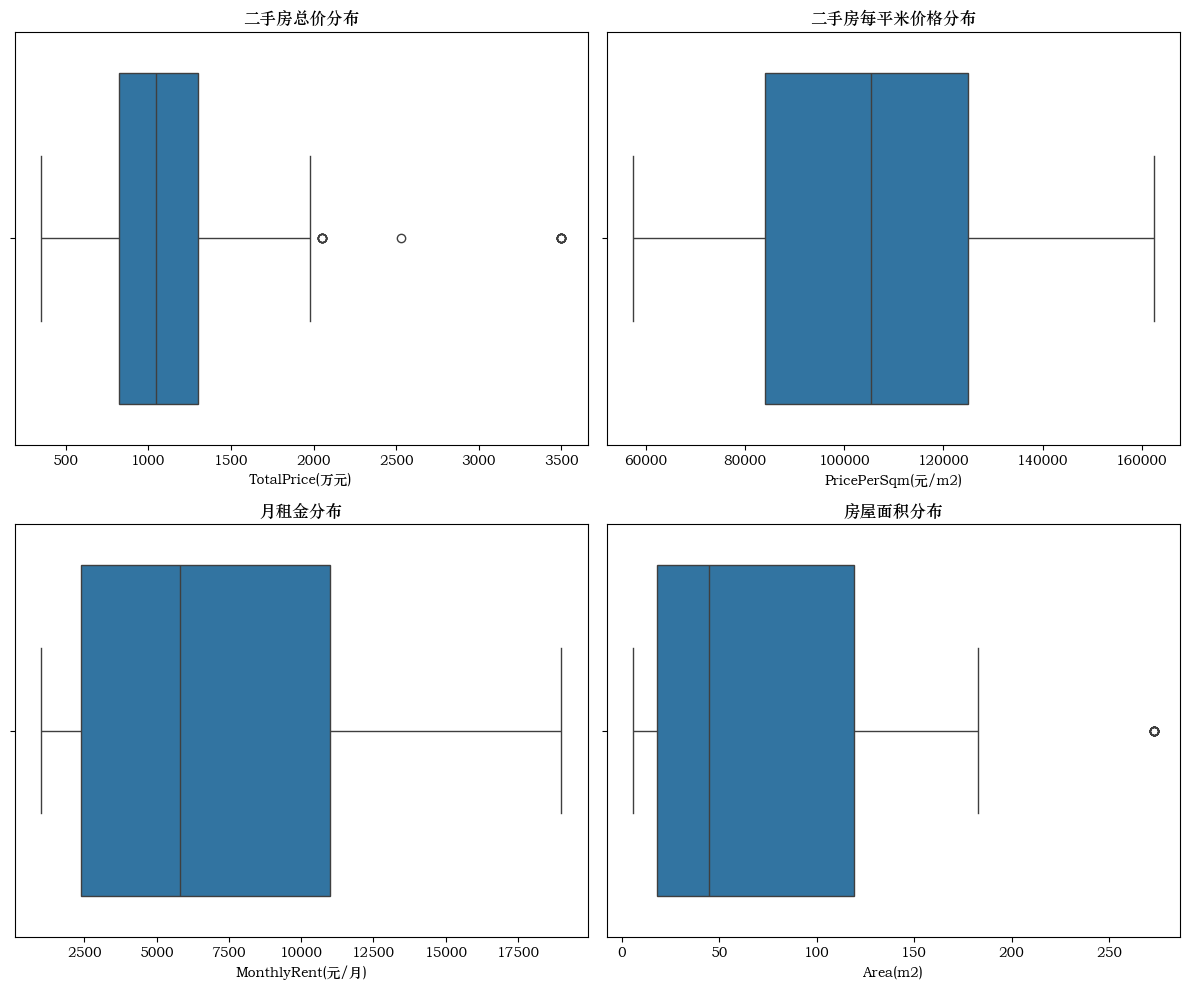

In [9]:
# 可视化检查异常值
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.boxplot(x=housing_df['TotalPrice'])
plt.xlabel('TotalPrice(万元)')
plt.title('二手房总价分布')

plt.subplot(2, 2, 2)
sns.boxplot(x=housing_df['PricePerSqm'])
plt.xlabel('PricePerSqm(元/m2)')
plt.title('二手房每平米价格分布')

plt.subplot(2, 2, 3)
sns.boxplot(x=rental_df['MonthlyRent'])
plt.xlabel('MonthlyRent(元/月)')
plt.title('月租金分布')

plt.subplot(2, 2, 4)
sns.boxplot(x=rental_df['Area'])
plt.xlabel('Area(m2)')
plt.title('房屋面积分布')

plt.tight_layout()
plt.savefig('3.1 outliers_check.png')
plt.show()

## 2. Get housing price per m2 and housing rent per m2(price/m2 and rent/m2) for each block

In [30]:
# Calculate median price to rent ratio for each block
median_price_per_sqm = all_housing.groupby('Block')['PricePerSqm'].median()
median_rent_per_sqm = all_rental.groupby('Block')['RentPerSqm'].median()

# 计算价格与租金的比率(年化)
price_to_rent_ratio = median_price_per_sqm / (median_rent_per_sqm * 12)

## 3. Figure A: Bar Plot the median price to rent ratio for each block

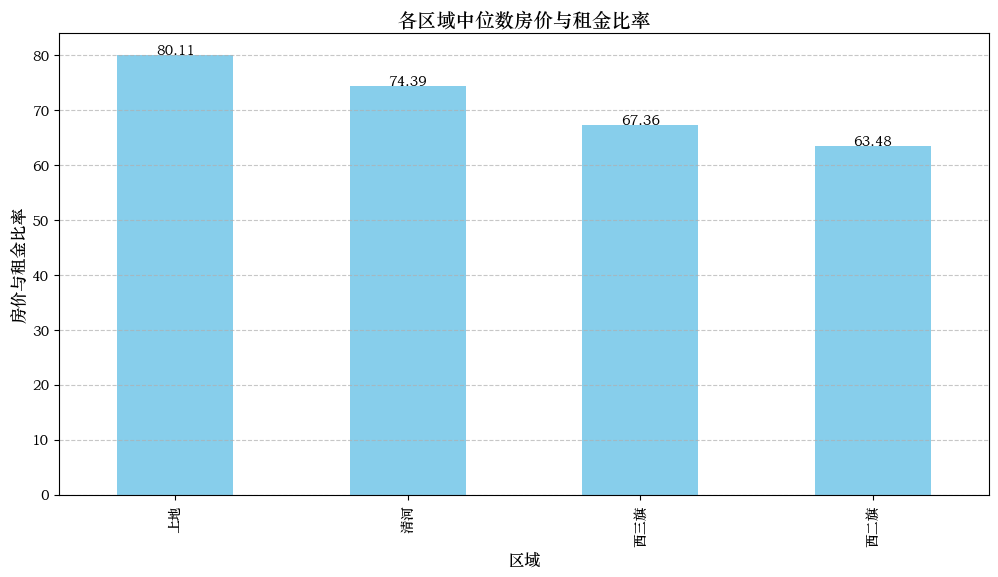

In [32]:
# 绘制中位数价格与租金比率的条形图(图A)
plt.figure(figsize=(12, 6))
ax = price_to_rent_ratio.plot(kind='bar', color='skyblue')
plt.title('各区域中位数房价与租金比率', fontsize=14)
plt.xlabel('区域', fontsize=12)
plt.ylabel('房价与租金比率', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 在柱子上显示数值
for i, v in enumerate(price_to_rent_ratio):
    ax.text(i, v + 0.1, f'{v:.2f}', ha='center', fontsize=10)

plt.savefig('3.2 Figure_A_Price_to_Rent_Ratio_All_Blocks.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Model

In [33]:
# 为每个区域定义模型并预测50平方米和100平方米的价格和租金
def fit_model_and_predict(housing_data, rental_data, block, m2_values):
    # 筛选特定区域的数据
    block_housing = housing_data[housing_data['Block'] == block]
    block_rental = rental_data[rental_data['Block'] == block]
    
    # 创建位置变量
    block_housing['location'] = 1
    block_rental['location'] = 1
    
    # 创建交互项
    block_housing['m2_x_location'] = block_housing['Area'] * block_housing['location']
    block_rental['m2_x_location'] = block_rental['Area'] * block_rental['location']
    
    # 使用更稳健的statsmodels库进行多元回归
    import statsmodels.api as sm
    
    # 模型1: 房价预测
    X_housing = block_housing[['Area', 'location', 'm2_x_location']]
    X_housing = sm.add_constant(X_housing)  # 添加常数项
    y_housing = block_housing['PricePerSqm']
    
    # 拟合模型
    try:
        model_housing = sm.OLS(y_housing, X_housing).fit()
        housing_params = model_housing.params
    except:
        # 简单线性回归作为备选
        housing_params = pd.Series({
            'const': block_housing['PricePerSqm'].mean(),
            'Area': 0,
            'location': 0,
            'm2_x_location': 0
        })
    
    # 模型2: 租金预测
    X_rental = block_rental[['Area', 'location', 'm2_x_location']]
    X_rental = sm.add_constant(X_rental)  # 添加常数项
    y_rental = block_rental['RentPerSqm']
    
    # 拟合模型
    try:
        model_rental = sm.OLS(y_rental, X_rental).fit()
        rental_params = model_rental.params
    except:
        # 简单线性回归作为备选
        rental_params = pd.Series({
            'const': block_rental['RentPerSqm'].mean(),
            'Area': 0,
            'location': 0,
            'm2_x_location': 0
        })
    
    # 预测不同面积的房价和租金
    results = {}
    for m2 in m2_values:
        # 预测每平方米房价
        pred_price_per_sqm = (housing_params.get('const', 0) + 
                              housing_params.get('Area', 0) * m2 + 
                              housing_params.get('location', 0) + 
                              housing_params.get('m2_x_location', 0) * m2)
        
        # 预测总房价
        pred_total_price = pred_price_per_sqm * m2
        
        # 预测每平方米月租金
        pred_rent_per_sqm = (rental_params.get('const', 0) + 
                             rental_params.get('Area', 0) * m2 + 
                             rental_params.get('location', 0) + 
                             rental_params.get('m2_x_location', 0) * m2)
        
        # 预测月租金
        pred_monthly_rent = pred_rent_per_sqm * m2
        
        # 计算价格与租金比率
        price_to_rent = pred_total_price / (pred_monthly_rent * 12)
        
        results[m2] = {
            'price_per_sqm': pred_price_per_sqm,
            'total_price': pred_total_price,
            'rent_per_sqm': pred_rent_per_sqm,
            'monthly_rent': pred_monthly_rent,
            'price_to_rent_ratio': price_to_rent
        }
    
    return results


In [34]:
# 为每个区域预测50平方米和100平方米的房价和租金
blocks = ['上地', '西三旗', '西二旗', '清河']
m2_values = [50, 100]
predictions = {}

In [35]:
for block in blocks:
    predictions[block] = fit_model_and_predict(all_housing, all_rental, block, m2_values)

# 从预测结果中提取价格与租金比率
price_to_rent_50 = {block: predictions[block][50]['price_to_rent_ratio'] for block in blocks}
price_to_rent_100 = {block: predictions[block][100]['price_to_rent_ratio'] for block in blocks}


C:\Users\86187\AppData\Local\Temp\ipykernel_20940\2577521312.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  block_housing['location'] = 1
C:\Users\86187\AppData\Local\Temp\ipykernel_20940\2577521312.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  block_rental['location'] = 1
C:\Users\86187\AppData\Local\Temp\ipykernel_20940\2577521312.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

### Figure B

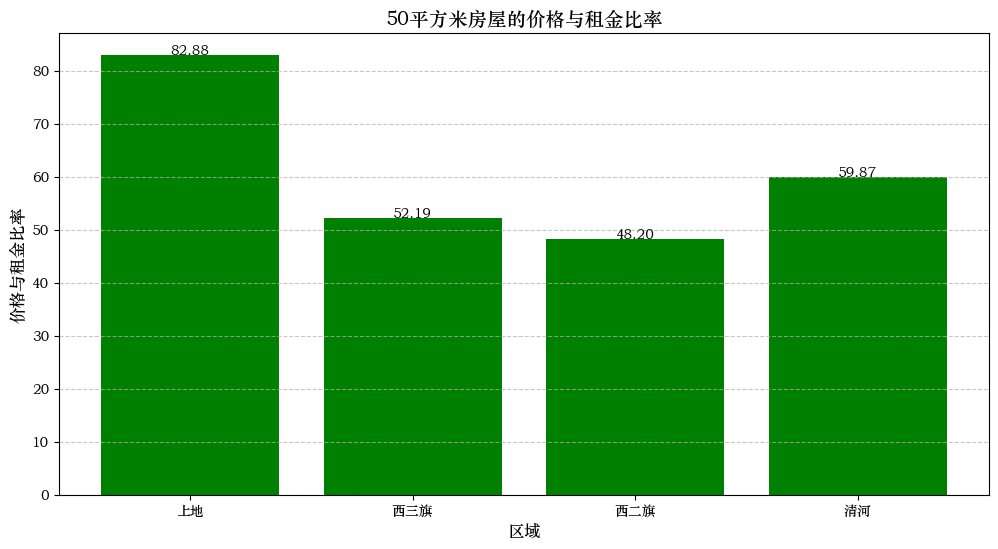

In [44]:
# 创建50平方米房屋的价格与租金比率条形图(图B)
plt.figure(figsize=(12, 6))
ax = plt.bar(price_to_rent_50.keys(), price_to_rent_50.values(), color='green')
plt.title('50平方米房屋的价格与租金比率', fontsize=14)
plt.xlabel('区域', fontsize=12)
plt.ylabel('价格与租金比率', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, (block, ratio) in enumerate(price_to_rent_50.items()):
    plt.text(i, ratio + 0.1, f'{ratio:.2f}', ha='center', fontsize=10)

plt.savefig('3.3 Figure_B_Price_to_Rent_Ratio_50sqm_All_Blocks.png', dpi=300, bbox_inches='tight')
plt.show()

### Figure C

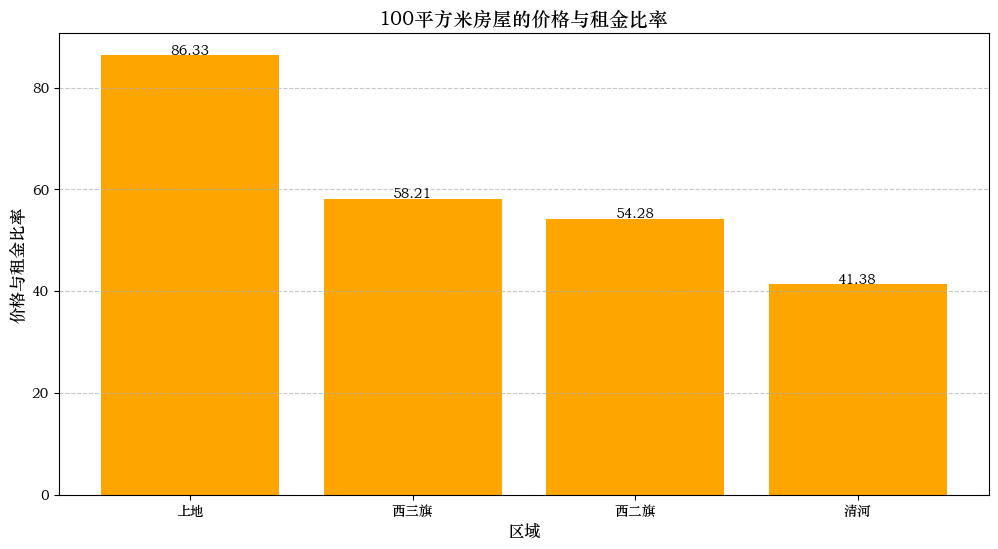

In [43]:
# 创建100平方米房屋的价格与租金比率条形图(图C)
plt.figure(figsize=(12, 6))
ax = plt.bar(price_to_rent_100.keys(), price_to_rent_100.values(), color='orange')
plt.title('100平方米房屋的价格与租金比率', fontsize=14)
plt.xlabel('区域', fontsize=12)
plt.ylabel('价格与租金比率', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 在柱子上显示数值
for i, (block, ratio) in enumerate(price_to_rent_100.items()):
    plt.text(i, ratio + 0.1, f'{ratio:.2f}', ha='center', fontsize=10)

plt.savefig('3.4 Figure_C_Price_to_Rent_Ratio_100sqm_All_Blocks.png', dpi=300, bbox_inches='tight')
plt.show()

### Results

In [38]:
# 输出结果汇总
print("\n======= 分析结果汇总 =======")
print("\n各区域中位数房价(元/平方米):")
for block, price in median_price_per_sqm.items():
    print(f"{block}: {price:.2f}")

print("\n各区域中位数月租金(元/平方米):")
for block, rent in median_rent_per_sqm.items():
    print(f"{block}: {rent:.2f}")

print("\n各区域中位数价格与租金比率:")
for block, ratio in price_to_rent_ratio.items():
    print(f"{block}: {ratio:.2f}")

print("\n50平方米房屋的价格与租金比率预测:")
for block, ratio in price_to_rent_50.items():
    print(f"{block}: {ratio:.2f}")

print("\n100平方米房屋的价格与租金比率预测:")
for block, ratio in price_to_rent_100.items():
    print(f"{block}: {ratio:.2f}")


======= 分析结果汇总 =======

各区域中位数房价(元/平方米):
上地: 105347.00
清河: 110101.01
西三旗: 72262.00
西二旗: 76933.00

各区域中位数月租金(元/平方米):
上地: 109.59
清河: 123.33
西三旗: 89.40
西二旗: 101.00

各区域中位数价格与租金比率:
上地: 80.11
清河: 74.39
西三旗: 67.36
西二旗: 63.48

50平方米房屋的价格与租金比率预测:
上地: 82.88
西三旗: 52.19
西二旗: 48.20
清河: 59.87

100平方米房屋的价格与租金比率预测:
上地: 86.33
西三旗: 58.21
西二旗: 54.28
清河: 41.38


In [39]:
# 将所有预测结果整理成表格
results_df = pd.DataFrame()


In [40]:
for m2 in m2_values:
    for block in blocks:
        pred = predictions[block][m2]
        row = {
            '区域': block,
            '面积(平方米)': m2,
            '预测单价(元/平方米)': round(pred['price_per_sqm'], 2),
            '预测总价(元)': round(pred['total_price'], 2),
            '预测月租单价(元/平方米)': round(pred['rent_per_sqm'], 2),
            '预测月租金(元)': round(pred['monthly_rent'], 2),
            '价格与租金比率': round(pred['price_to_rent_ratio'], 2)
        }
        results_df = pd.concat([results_df, pd.DataFrame([row])])

In [42]:
# 保存预测结果表格
results_df
results_df.to_csv('predicted_results_all_blocks.csv', index=False)